In [3]:
from torchvision import datasets, transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [5]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.0, 1.0)
])

mnist_train = datasets.FashionMNIST('./data', train=True, download=True, transform=transform_train)
mnist_test = datasets.FashionMNIST('./data', train=False, download=True, transform=transform_train)

Label of image above: 5


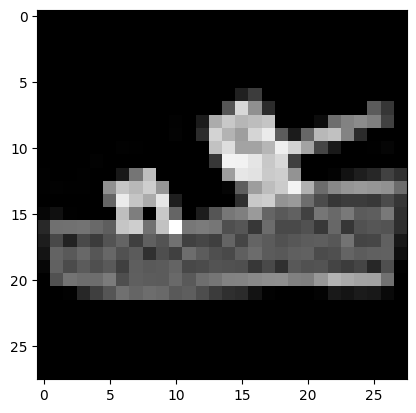

Label of image above: 8


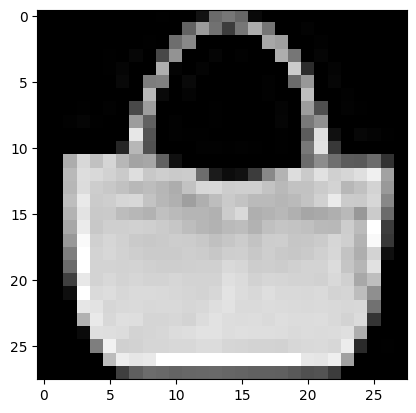

In [6]:
label = mnist_train[12][1]
print('Label of image above:', label)
img = mnist_train[12][0].numpy()
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

label = mnist_train[100][1]
print('Label of image above:', label)
img = mnist_train[100][0].numpy()
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

In [12]:
batch_size = 1024
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=1)

In [13]:
for data, label in mnist_train_loader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([1024, 1, 28, 28])
torch.Size([1024])


In [55]:
class MNIST_custom(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 28x28x1
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5) # (28 - 5 + 0)/ 1 + 1 = 24
        self.conv2 = nn.Conv2d(12, 24, kernel_size=5) # (22 - 5) + 1 = 20
        
        self.mxpool = nn.MaxPool2d(2) # 12x12x32

        # Maxpooling 4x4x64

        self.fc1 = nn.Linear(10 * 10 * 24, 512)
        self.fc2 = nn.Linear(512, 10)

    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.mxpool(F.relu(self.conv2(x)))

        x = x.view(-1, 10 * 10 * 24)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x


## Adam

In [56]:
model = MNIST_custom()
if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
model

MNIST_custom(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [58]:
num_epochs = 20

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = model(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append(100 * correct.cpu() / float(len(mnist_train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = model(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(mnist_valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/20, Tr Loss: 0.7926, Tr Acc: 71.7983, Val Loss: 0.4162, Val Acc: 84.9500
Epoch 2/20, Tr Loss: 0.3466, Tr Acc: 87.2117, Val Loss: 0.3394, Val Acc: 87.1800
Epoch 3/20, Tr Loss: 0.2848, Tr Acc: 89.3433, Val Loss: 0.3177, Val Acc: 88.2300
Epoch 4/20, Tr Loss: 0.2529, Tr Acc: 90.5850, Val Loss: 0.3027, Val Acc: 88.9700
Epoch 5/20, Tr Loss: 0.2206, Tr Acc: 91.7767, Val Loss: 0.2759, Val Acc: 90.0500
Epoch 6/20, Tr Loss: 0.1974, Tr Acc: 92.6717, Val Loss: 0.2859, Val Acc: 89.9000
Epoch 7/20, Tr Loss: 0.1776, Tr Acc: 93.3717, Val Loss: 0.2873, Val Acc: 89.9300
Epoch 8/20, Tr Loss: 0.1513, Tr Acc: 94.3717, Val Loss: 0.3094, Val Acc: 89.8600
Epoch 9/20, Tr Loss: 0.1361, Tr Acc: 94.7983, Val Loss: 0.3197, Val Acc: 90.3400
Epoch 10/20, Tr Loss: 0.1183, Tr Acc: 95.5933, Val Loss: 0.3339, Val Acc: 90.7400
Epoch 11/20, Tr Loss: 0.1044, Tr Acc: 96.0833, Val Loss: 0.3341, Val Acc: 90.3900
Epoch 12/20, Tr Loss: 0.0851, Tr Acc: 96.8283, Val Loss: 0.3831, Val Acc: 90.2700
Epoch 13/20, Tr Loss: 0.0

## SGD

In [61]:
model = MNIST_custom()
if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [62]:
num_epochs = 20

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = model(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append(100 * correct.cpu() / float(len(mnist_train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = model(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(mnist_valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/20, Tr Loss: 1.9821, Tr Acc: 36.6967, Val Loss: 1.5405, Val Acc: 45.7200
Epoch 2/20, Tr Loss: 0.8779, Tr Acc: 67.6633, Val Loss: 0.7150, Val Acc: 73.8500
Epoch 3/20, Tr Loss: 0.6489, Tr Acc: 75.3800, Val Loss: 0.6254, Val Acc: 76.3500
Epoch 4/20, Tr Loss: 0.5755, Tr Acc: 78.3417, Val Loss: 0.5673, Val Acc: 78.9800
Epoch 5/20, Tr Loss: 0.5337, Tr Acc: 80.1683, Val Loss: 0.5380, Val Acc: 80.2500
Epoch 6/20, Tr Loss: 0.4947, Tr Acc: 81.8167, Val Loss: 0.4991, Val Acc: 82.2000
Epoch 7/20, Tr Loss: 0.4732, Tr Acc: 82.8050, Val Loss: 0.4830, Val Acc: 83.1700
Epoch 8/20, Tr Loss: 0.4441, Tr Acc: 84.2350, Val Loss: 0.4635, Val Acc: 83.6600
Epoch 9/20, Tr Loss: 0.4216, Tr Acc: 85.0367, Val Loss: 0.4395, Val Acc: 84.6100
Epoch 10/20, Tr Loss: 0.4077, Tr Acc: 85.5000, Val Loss: 0.4317, Val Acc: 85.0000
Epoch 11/20, Tr Loss: 0.3948, Tr Acc: 85.9367, Val Loss: 0.4419, Val Acc: 83.6900
Epoch 12/20, Tr Loss: 0.3800, Tr Acc: 86.4350, Val Loss: 0.4095, Val Acc: 85.5100
Epoch 13/20, Tr Loss: 0.3

## RMSprop

In [64]:
model = MNIST_custom()
if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [65]:
num_epochs = 20

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = model(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append(100 * correct.cpu() / float(len(mnist_train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = model(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(mnist_valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/20, Tr Loss: 91.2199, Tr Acc: 12.4567, Val Loss: 1.9677, Val Acc: 29.4300
Epoch 2/20, Tr Loss: 1.3175, Tr Acc: 52.7917, Val Loss: 0.8371, Val Acc: 68.4800
Epoch 3/20, Tr Loss: 0.7707, Tr Acc: 69.9850, Val Loss: 0.7374, Val Acc: 71.6200
Epoch 4/20, Tr Loss: 0.6863, Tr Acc: 72.5900, Val Loss: 0.7115, Val Acc: 72.7200
Epoch 5/20, Tr Loss: 0.6302, Tr Acc: 75.2233, Val Loss: 0.6588, Val Acc: 75.2300
Epoch 6/20, Tr Loss: 0.5911, Tr Acc: 76.9583, Val Loss: 0.6747, Val Acc: 74.0500
Epoch 7/20, Tr Loss: 0.6938, Tr Acc: 74.4333, Val Loss: 0.5876, Val Acc: 78.5500
Epoch 8/20, Tr Loss: 0.5144, Tr Acc: 79.9533, Val Loss: 0.6008, Val Acc: 77.8600
Epoch 9/20, Tr Loss: 0.5061, Tr Acc: 80.7350, Val Loss: 0.5942, Val Acc: 78.1200
Epoch 10/20, Tr Loss: 0.4943, Tr Acc: 81.2533, Val Loss: 0.4995, Val Acc: 81.0900
Epoch 11/20, Tr Loss: 0.4999, Tr Acc: 81.0900, Val Loss: 0.4704, Val Acc: 82.4100
Epoch 12/20, Tr Loss: 0.4652, Tr Acc: 82.6783, Val Loss: 0.4886, Val Acc: 81.9800
Epoch 13/20, Tr Loss: 1.

### Conclusion:
I tried to show the same architecture but with different optimization methods which clearly indicates the one that performing better - Adam.

1. Adam accuracy - 98.3% training
2. SGD accuracy - 87.8% training
3. RMSprop accuracy - 85.1% training